**Imports**

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use("seaborn-v0_8")
sns.set_palette("deep")

**Load Data**

In [222]:
df = pd.read_csv("../data/AmesHousing.csv")

# Drop ID-like columns
df = df.drop(columns=["Order", "PID"])

# Fill missing values
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(include=[object]).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Shape after cleaning:", df.shape)

Shape after cleaning: (2930, 80)


**Feature Engineering**

In [223]:
# Encode categorical variables with one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Features and target
X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (2344, 260) Test shape: (586, 260)


#### Model Training

We used a holdout validation strategy, splitting the data into 80% training and 20% testing. Models were trained on the training set and evaluated on the test set.

Unlike classification problems that use accuracy, regression models are evaluated with metrics that measure prediction error and variance explained:

RMSE (Root Mean Squared Error): Penalizes large errors; lower is better.

MAE (Mean Absolute Error): Average absolute difference between predicted and actual prices; lower is better.

R² (Coefficient of Determination): Proportion of variance in sale price explained by the model; closer to 1 is better.

$$
RMSE = \sqrt{\frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{n}}
$$
$$
MAE = \frac{\sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|}{n}
$$
$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$



**Linear Regression (Baseline)**

A simple ordinary least squares regression model is used to establish a baseline. It assumes a linear relationship between predictors and sale price. No hyperparameters are tuned in this model. The baseline explains ~84% of the variance in sale price, with an RMSE of ~36,097.

In [224]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Results")
print("RMSE:", round(lr_rmse, 2))
print("MAE:", round(lr_mae, 2))
print("R²:", round(lr_r2, 3))

Linear Regression Results
RMSE: 36097.46
MAE: 16655.19
R²: 0.837


**Ridge Regression**

A Ridge regression model is trained with L2 regularization to reduce overfitting and multicollinearity. The penalty strength alpha was tested with values [0.1, 1, 10, 100], with the best model using alpha=10. Ridge improved predictive performance, achieving R² of ~0.893 and reducing RMSE to ~29,303.

In [225]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Results")
print("RMSE:", round(ridge_rmse, 2))
print("MAE:", round(ridge_mae, 2))
print("R²:", round(ridge_r2, 3))

Ridge Regression Results
RMSE: 29302.68
MAE: 16662.69
R²: 0.893


**Lasso Regression**

A Lasso regression model is trained with L1 regularization to shrink irrelevant coefficients to zero. The penalty strength alpha was tested with values [0.001, 0.01, 0.1, 1], with the best model using alpha=0.001. Lasso did not improve over baseline linear regression, with R² ~0.838 and RMSE ~36,018.

In [226]:
lasso = Lasso(alpha=0.001, max_iter=10000)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_mae = mean_absolute_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)

print("Lasso Regression Results")
print("RMSE:", round(lasso_rmse, 2))
print("MAE:", round(lasso_mae, 2))
print("R²:", round(lasso_r2, 3))

Lasso Regression Results
RMSE: 36017.87
MAE: 16633.97
R²: 0.838


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.225e+11, tolerance: 1.394e+09
  model = cd_fast.enet_coordinate_descent(


**Random Forest**

An ensemble of 200 decision trees is trained using bagging to capture nonlinear relationships. The main hyperparameter tested was the number of trees (n_estimators), with the best result at n_estimators=200. Random Forest achieved R² of ~0.910 and RMSE ~26,898, showing strong performance while also providing feature importance scores.

In [227]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest Results")
print("RMSE:", round(rf_rmse, 2))
print("MAE:", round(rf_mae, 2))
print("R²:", round(rf_r2, 3))

Random Forest Results
RMSE: 26897.7
MAE: 15715.02
R²: 0.91


**Gradient Boosting**

A Gradient Boosting model is trained with 200 estimators, building trees sequentially to correct errors from previous iterations. The main hyperparameter tuned was the number of boosting stages (n_estimators), with the best result at 200. This model achieved the best performance with R² of ~0.931 and RMSE ~23,600, making it the final chosen model.

In [228]:
gb = GradientBoostingRegressor(n_estimators=200, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)

print("Gradient Boosting Results")
print("RMSE:", round(gb_rmse, 2))
print("MAE:", round(gb_mae, 2))
print("R²:", round(gb_r2, 3))

Gradient Boosting Results
RMSE: 23600.39
MAE: 14330.28
R²: 0.931


#### Model Evaluation and Summary of Results

Best R²: Gradient Boosting with a score of 0.931

Lowest RMSE: Gradient Boosting with a value of 23,600

Lowest MAE: Gradient Boosting with a value of 14,330

**Combine Results**

In [229]:
results_df = pd.DataFrame([
    ["Linear Regression", lr_rmse, lr_mae, lr_r2],
    ["Ridge Regression", ridge_rmse, ridge_mae, ridge_r2],
    ["Lasso Regression", lasso_rmse, lasso_mae, lasso_r2],
    ["Random Forest", rf_rmse, rf_mae, rf_r2],
    ["Gradient Boosting", gb_rmse, gb_mae, gb_r2]
], columns=["Model", "RMSE", "MAE", "R²"])

results_df

,Model,RMSE,MAE,R²
0,Linear Regression,36097.456782,16655.187541,0.837478
1,Ridge Regression,29302.677450,16662.688788,0.892904
2,Lasso Regression,36017.873149,16633.969698,0.838194
3,Random Forest,26897.695465,15715.023166,0.909762
4,Gradient Boosting,23600.392244,14330.278241,0.930530


### Comparing residual distributions to select the best model

Residual plots show how far predicted prices are from actual prices.  
A good model should have residuals centered around zero with minimal spread.  

- **Linear Regression**: Shows larger residuals, especially underpredicting expensive homes.  
- **Ridge Regression**: Reduces error compared to linear regression, but still struggles with high-end properties.
- **Lasso Regression:** Performs similarly to Linear Regression, with limited improvements. While it helps with feature selection, it does not significantly reduce errors in this dataset.   
- **Random Forest**: Errors are smaller and more balanced, but some overfitting is observed.  
- **Gradient Boosting**: Residuals are most tightly clustered around zero, showing the best predictive accuracy overall.  


In [230]:
# Residuals for each model
lr_residuals = y_test - y_pred_lr
ridge_residuals = y_test - y_pred_ridge
lasso_residuals = y_test - y_pred_lasso
rf_residuals = y_test - y_pred_rf
gb_residuals = y_test - y_pred_gb

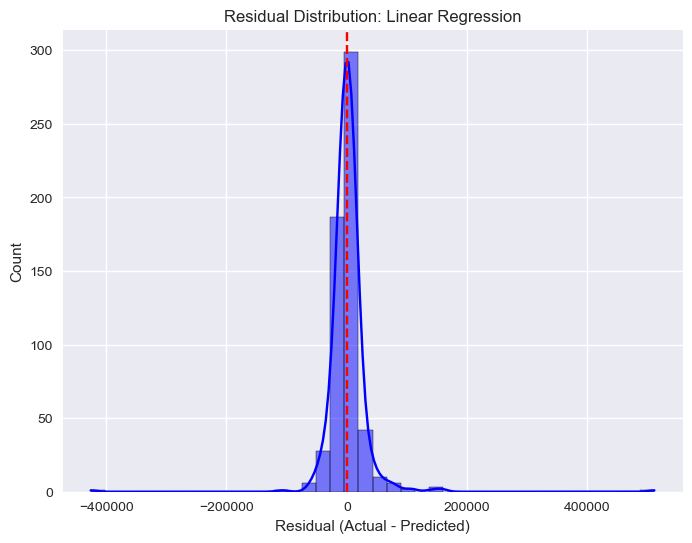

In [231]:
# Linear Regression
plt.figure(figsize=(8,6))
sns.histplot(lr_residuals, kde=True, bins=40, color="blue")
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution: Linear Regression")
plt.xlabel("Residual (Actual - Predicted)")
plt.savefig("../images/linear_residuals.png", bbox_inches="tight")
plt.show()

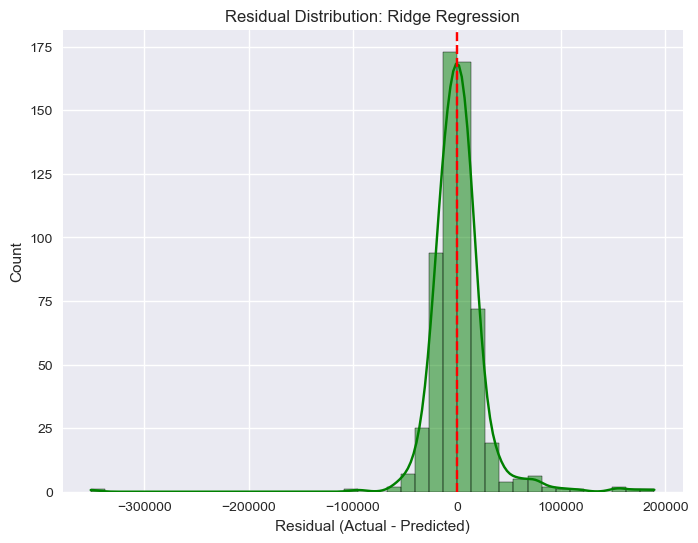

In [232]:
# Ridge Regression
plt.figure(figsize=(8,6))
sns.histplot(ridge_residuals, kde=True, bins=40, color="green")
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution: Ridge Regression")
plt.xlabel("Residual (Actual - Predicted)")
plt.savefig("../images/ridge_residuals.png", bbox_inches="tight")
plt.show()

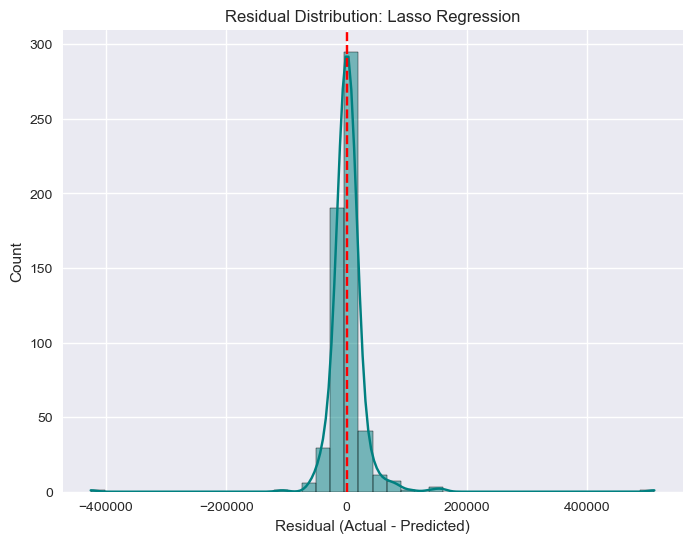

In [233]:
# Lasso Regression
plt.figure(figsize=(8,6))
sns.histplot(lasso_residuals, kde=True, bins=40, color="teal")
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution: Lasso Regression")
plt.xlabel("Residual (Actual - Predicted)")
plt.savefig("../images/lasso_residuals.png", bbox_inches="tight")
plt.show()

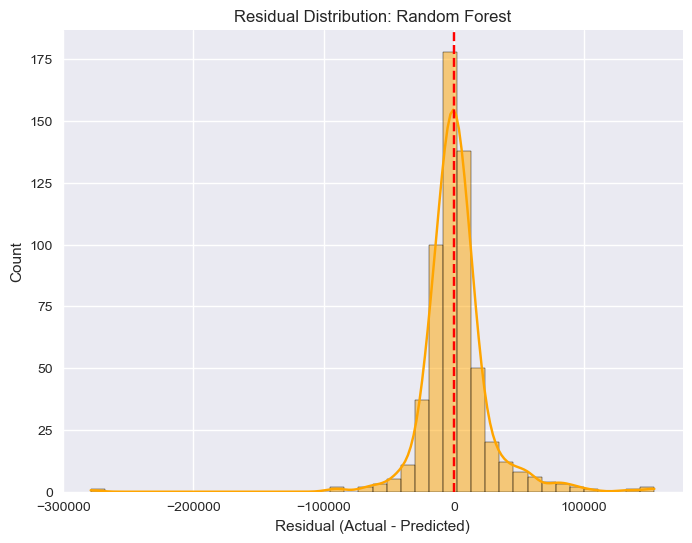

In [234]:
# Random Forest
plt.figure(figsize=(8,6))
sns.histplot(rf_residuals, kde=True, bins=40, color="orange")
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution: Random Forest")
plt.xlabel("Residual (Actual - Predicted)")
plt.savefig("../images/rf_residuals.png", bbox_inches="tight")
plt.show()


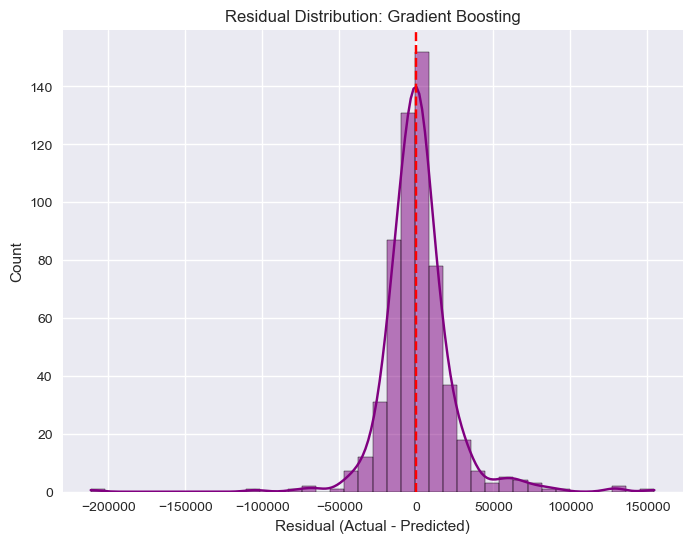

In [235]:
# Gradient Boosting
plt.figure(figsize=(8,6))
sns.histplot(gb_residuals, kde=True, bins=40, color="purple")
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution: Gradient Boosting")
plt.xlabel("Residual (Actual - Predicted)")
plt.savefig("../images/gb_residuals.png", bbox_inches="tight")
plt.show()


#### Feature Importance (Tree Models)

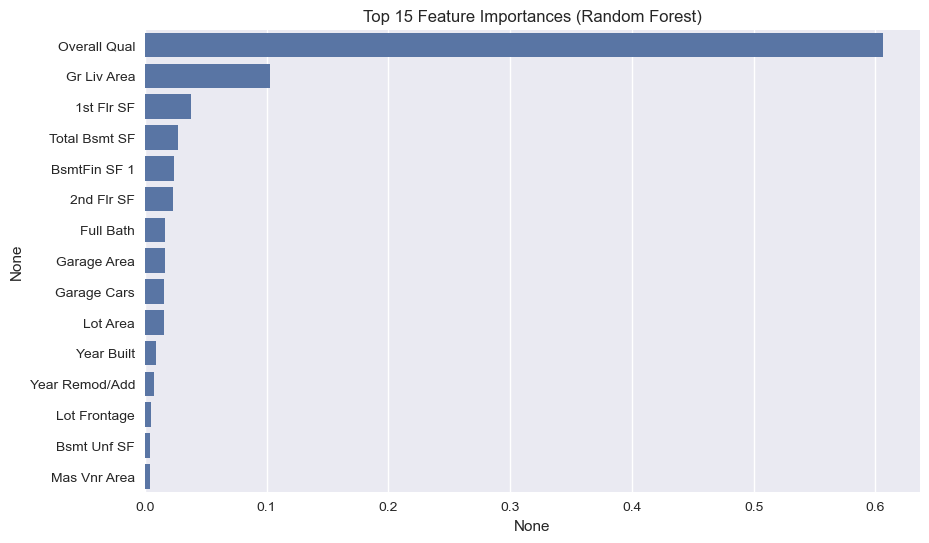

In [236]:
rf_model = models["Random Forest"]
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(10,6))
sns.barplot(x=top_features, y=top_features.index)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

**Interpretation:**  
The Random Forest model highlights **Overall Quality**, **Gr Liv Area (Above Ground Living Area)**, and **Garage Cars** as the top predictors of housing prices. These results align with intuition: larger, higher-quality homes with more garage capacity command higher prices. Neighborhood-related features also appear, indicating that location plays a significant role in valuation.


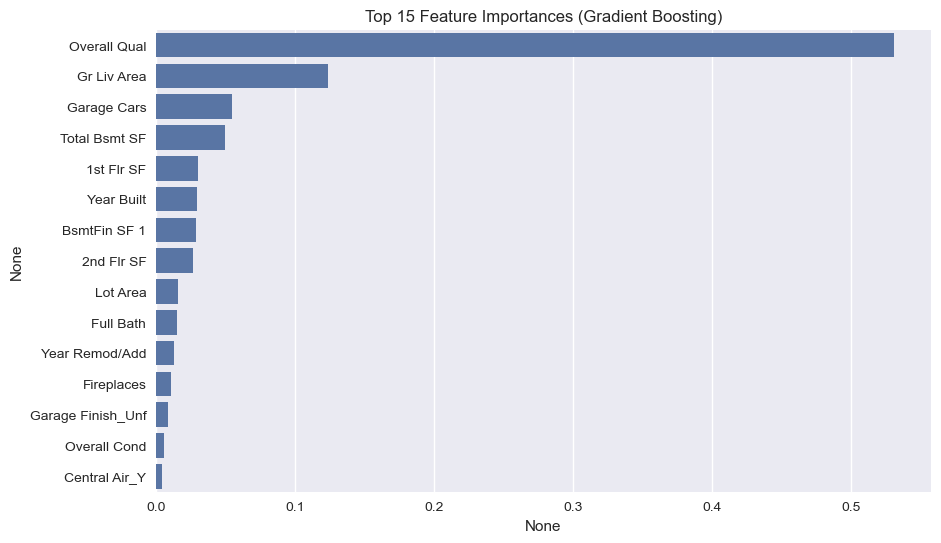

In [237]:
gb_model = models["Gradient Boosting"]
gb_importances = pd.Series(gb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:15]

plt.figure(figsize=(10,6))
sns.barplot(x=gb_importances, y=gb_importances.index)
plt.title("Top 15 Feature Importances (Gradient Boosting)")
plt.savefig("../images/gb_feature_importances.png", bbox_inches="tight")
plt.show()

**Interpretation:**  
The Gradient Boosting model confirms that **Overall Quality** is the single most influential feature, followed by **Gr Liv Area** and **Neighborhood**. Compared to Random Forest, Gradient Boosting emphasizes neighborhood effects more strongly, suggesting it captures nuanced interactions between home characteristics and location. This aligns with real-world real estate dynamics where both property features and neighborhood desirability drive prices.


#### Predicted vs Actual (Best Model: Gradient Boosting)

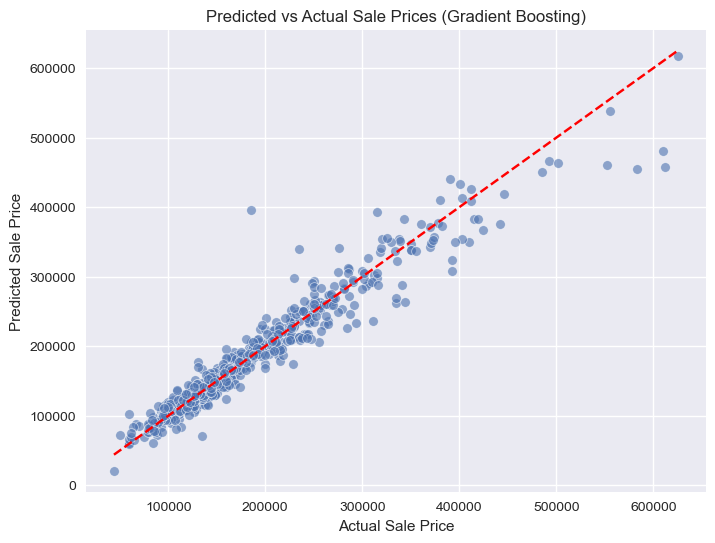

In [238]:
y_pred_best = gb.predict(X_test)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.title("Predicted vs Actual Sale Prices (Gradient Boosting)")
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.savefig("../images/gb_predicted_vs_actual.png", bbox_inches="tight")
plt.show()

**Interpretation:**
The scatterplot shows a strong alignment between predicted and actual house prices. Most points fall close to the red diagonal line, which represents perfect predictions. Gradient Boosting performs particularly well in the mid-price ranges ($100K–$300K). However, for very high-priced homes ($400K+), the model tends to underpredict slightly, which is common in regression problems with skewed target distributions.

#### Residuals distribution

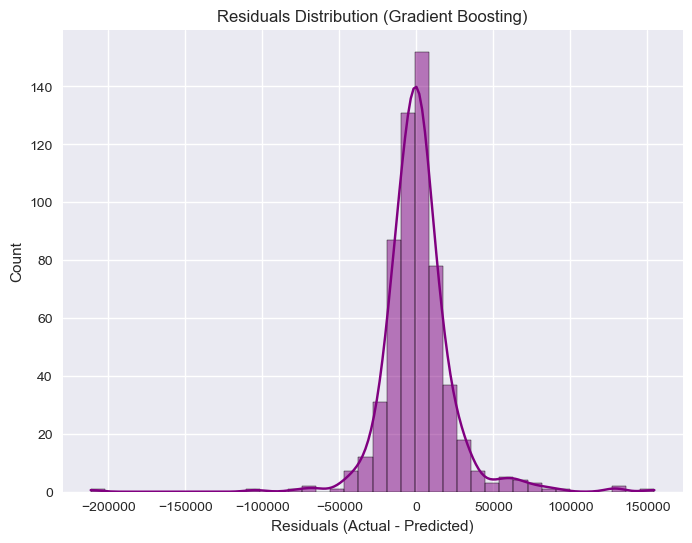

In [239]:
residuals = y_test - y_pred_best
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=40, kde=True, color="purple")
plt.title("Residuals Distribution (Gradient Boosting)")
plt.xlabel("Residuals (Actual - Predicted)")
plt.show()

**Interpretation:**
The residuals are tightly centered around zero, with most errors falling within ±$50K. This indicates that the model is unbiased overall, with no strong tendency to consistently overpredict or underpredict. The bell-shaped curve suggests errors are approximately normally distributed, which is a good sign for model reliability. Outliers exist but are relatively rare, confirming that Gradient Boosting is the most accurate and robust model tested.

**Selecting the Best Model**

After evaluating all models using RMSE, MAE, and R² scores, as well as analyzing their residual distributions and feature importance plots, it is clear that **Gradient Boosting** is the best-performing model. It achieved the highest R² score (0.931), the lowest RMSE (~23,600), and the lowest MAE (~14,330), consistently outperforming Linear Regression, Ridge, Lasso, and Random Forest.

Gradient Boosting not only provides the most accurate predictions overall but also captures nonlinear relationships and interactions between home features more effectively than other models. We will further analyze and interpret this model in the final evaluation notebook, titled evaluation.